In [1]:
import pandas as pd
import mysql.connector as mc

In [2]:
fecha_ini='2018-12-01 00:00:00'
fecha_fin='2018-12-31 21:00:00'
mes='10'

In [3]:
pd.options.display.max_rows = 5
pd.options.display.float_format = '{:.2f} %'.format

In [4]:
db = mc.connect(
  host='172.18.55.6',
  user='comandato',
  passwd='comandato123',
)

##  <center><font color='blue'>EXTRAER INFRACTORES</font></center>

In [5]:
consulta_contarivr="""
    SELECT count(*)
    FROM
        sistemecuador_atm.gestion_ivr
    WHERE
        FECHA_GESTION BETWEEN '{0}' AND '{1}'
    AND 
        ACCION_REALIZADA = 'ENVIAR IVR';
""".format(fecha_ini,fecha_fin)

In [6]:
contador=pd.read_sql(consulta_contarivr, con=db)

In [7]:
contador

,count(*)
0,91129


In [8]:
infractores=""" SELECT Cedula ,count(*) as multas,
                    sum(Saldo) as monto,Cartera,
                    min(Dias_mora) as menor_mora 
                FROM 
                    SISTEMECUADOR_ATM.MULTAS_MENSUALES 
                where 
                    Mes={0} group by Cedula,Cartera""".format(mes)

In [9]:
bd_infractores=pd.read_sql(infractores, con=db)

In [10]:
def agregar_ceros(base):
    ced=base['Cedula']
    if len(ced)==9 or len(ced)==12 :
        if ced.isdigit():
            return '0'+ced
    return ced

In [11]:
bd_infractores['CED']=bd_infractores.apply(agregar_ceros,axis=1)

In [12]:
bd_infractores.drop('Cedula',1,inplace=True)

##  <center><font color='blue'>EXTRAER GESTIONES ASESOR</font></center>

In [13]:
gestion_asesor="""SELECT 
                    NRO_IDENTIFICACION_CLIENTE as CED, FECHA_GESTION,RESPUESTA_OBTENIDA,CONTACTO_GESTIONO,MOTIVO_NO_PAGO
                FROM 
                    sistemecuador_atm.gestion
                WHERE
                    ACCION_REALIZADA = 'HACER LLAMADA'
                AND
                    FECHA_GESTION BETWEEN '{0}' AND '{1}'
                AND
                    COMENTARIOS_GESTIONO NOT LIKE '%CAMPAÑA CONVENIO%';""".format(fecha_ini,fecha_fin)

In [14]:
bd_gstasesor=pd.read_sql(gestion_asesor, con=db)

In [15]:
bd_gstasesor['CONTACTO_GESTIONO']=bd_gstasesor['CONTACTO_GESTIONO'].astype('category')
bd_gstasesor['CONTACTO_GESTIONO']=bd_gstasesor['CONTACTO_GESTIONO'].cat.set_categories(['CLIENTE','TERC. VALIDO','TERC. NO VALIDO','NO CONTACTO','SIN GESTION'])
bd_gstasesor=bd_gstasesor.sort_values(by=['CONTACTO_GESTIONO'],ascending=[True])
bd_gstasesor.drop_duplicates(['CED'], keep='first',inplace=True)

##  <center><font color='blue'>EXTRAER GESTIONES IVR</font></center>

In [16]:
consulta_ivr="""
    SELECT NRO_IDENTIFICACION_CLIENTE as CED,
        RESPUESTA_OBTENIDA as RESPUESTAIVR
    FROM
        sistemecuador_atm.gestion_ivr
    WHERE
        FECHA_GESTION BETWEEN '{0}' AND '{1}'
    AND 
        ACCION_REALIZADA = 'ENVIAR IVR';
""".format(fecha_ini,fecha_fin)

In [17]:
bd_gstivr=pd.read_sql(consulta_ivr, con=db)

In [18]:
bd_gstivr["RESPUESTAIVR"] = bd_gstivr["RESPUESTAIVR"].astype('category')
bd_gstivr["RESPUESTAIVR"]  = bd_gstivr["RESPUESTAIVR"].cat.set_categories(["CONTESTO IVR","SMS ENVIADO","NO CONTESTO IVR","SIN IVR"])
bd_gstivr=bd_gstivr.sort_values(by=['RESPUESTAIVR'],ascending=[True])
bd_gstivr.drop_duplicates(['CED'], keep='first',inplace=True)

##  <center><font color='blue'>CRUCE DE GESTIONES</font></center>

In [19]:
combinar_ivr=pd.merge(bd_infractores,bd_gstivr,on=['CED'],how='left')
combinar_ivr['RESPUESTAIVR']= combinar_ivr['RESPUESTAIVR'].fillna('SIN IVR')

In [20]:
combinar_ivr.count()

multas          69010
monto           69010
                ...  
CED             69010
RESPUESTAIVR    69010
Length: 6, dtype: int64

In [21]:
combinar_gest=pd.merge(combinar_ivr,bd_gstasesor,on=['CED'],how='left')
combinar_gest['CONTACTO_GESTIONO']= combinar_gest['CONTACTO_GESTIONO'].fillna('SIN GESTION')

In [22]:
pd.crosstab(index=combinar_gest['Cartera'],columns=combinar_gest['CONTACTO_GESTIONO'],margins=True)

CONTACTO_GESTIONO,CLIENTE,TERC. VALIDO,TERC. NO VALIDO,NO CONTACTO,SIN GESTION,All
Cartera,,,,,,
CORRIENTE,829,452,125,2316,14127,17849
MENOR,990,338,175,1816,47842,51161
All,1819,790,300,4132,61969,69010


In [23]:
porcentaje_gestion=pd.crosstab(index=combinar_gest['Cartera'],columns=combinar_gest['CONTACTO_GESTIONO']).apply(lambda r:r/r.sum()*100,axis=1)
porcentaje_gestion

CONTACTO_GESTIONO,CLIENTE,TERC. VALIDO,TERC. NO VALIDO,NO CONTACTO,SIN GESTION
Cartera,,,,,
CORRIENTE,4.64 %,2.53 %,0.70 %,12.98 %,79.15 %
MENOR,1.94 %,0.66 %,0.34 %,3.55 %,93.51 %


In [24]:
porcentaje_gestion.plot(kind='bar',stacked=True,title='CONTACTABILIDAD')

In [25]:
wivr=pd.crosstab(index=combinar_gest['Cartera'],columns=combinar_gest['RESPUESTAIVR'],margins=False)
wivr

RESPUESTAIVR,SIN IVR
Cartera,
CORRIENTE,17849
MENOR,51161


In [26]:
porcentaje_gestionivr=pd.crosstab(index=combinar_gest['Cartera'],columns=combinar_gest['RESPUESTAIVR']).apply(lambda r:r/r.sum()*100,axis=1)
porcentaje_gestionivr

RESPUESTAIVR,SIN IVR
Cartera,
CORRIENTE,100.00 %
MENOR,100.00 %


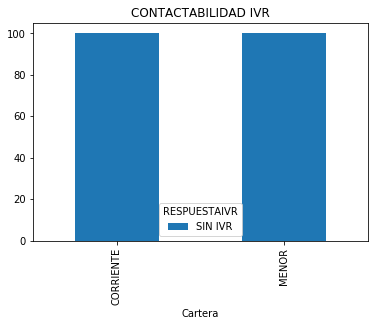

In [27]:
porcentaje_gestionivr.plot(kind='bar',stacked=True,title='CONTACTABILIDAD IVR')

In [28]:
combinar_gest.head(20)

,multas,monto,Cartera,menor_mora,CED,RESPUESTAIVR,FECHA_GESTION,RESPUESTA_OBTENIDA,CONTACTO_GESTIONO,MOTIVO_NO_PAGO
0,1,57.90 %,MENOR,192,00042448K,SIN IVR,NaT,NaN,SIN GESTION,NaN
1,2,135.10 %,MENOR,22,1000005262,SIN IVR,2018-12-04 11:40:38,NO CONTESTA,NO CONTACTO,
...,...,...,...,...,...,...,...,...,...,...
18,1,57.90 %,MENOR,119,1000907038,SIN IVR,NaT,NaN,SIN GESTION,NaN
19,1,34.00 %,MENOR,1002,1000924884,SIN IVR,NaT,NaN,SIN GESTION,NaN


In [29]:
writer = pd.ExcelWriter('CONTACTABILIDAD SEPTIEMBRE.xlsx', engine='xlsxwriter')
combinar_gest.to_excel(writer, sheet_name='TOTAL')
worksheet = writer.sheets['TOTAL']
writer.save()